In [32]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

import torch

from autogen import ConversableAgent, GroupChat
from autogen_agentchat.teams import DiGraphBuilder, GraphFlow
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.messages import TextMessage
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline

from Utl import process_locs_buildings, acs_county_data, read_from_csv, aggregate_buildings
import re

import matplotlib.pyplot as plt
import math

import pandas as pd
from io import StringIO
import numpy as np

In [2]:
torch.cuda.is_available()

True

# Model and Agents Setup

In [ ]:
llm_config = {
    "config_list": [
        {
            "model": "grok-3-beta",
            "base_url": "https://api.x.ai/v1",
            "api_key": "xai-fHtZRUQKqSpojINpKdag8b7vJY1FOVYKkZqTouDPMIEspHQXPTtOGuvjvXpy3IMi7Bw6Wb32Sir9KwCN",
        }
    ]
}

aggregated_population_manager = ConversableAgent(
    name="AggregatedActivityManager",
    system_message=(
      "You are the Population Agent in the aggregated pipeline.  "
      "You have access to a function: get_acs_data(county: str, state: str) → returns "
      "the latest ACS distributions for age, gender, education, and income in that county.  "
      "Your task is:\n"
      "  1. Call get_acs_data with the user-specified county and state.\n"
      "  2. Use the returned demographics to form NUM_CLUSTERS distinct population clusters.  "
      "Each cluster should include: cluster_id, population_count, and a brief demographic_summary "
      "(age & income fractions).\n"
      "  3. Clusters should reflect plausible travel-behavior archetypes.\n"
      "Return the clusters as a plain-text list, one cluster per line.\n"
      "Each line of cluster should contain as many attributes distribution as possible.\n"
      "Each line of cluster should start with a symbol '###'"
      "  4. When start generation, print 'START'. Once the task is complete, return 'TERMINATE'."
    ),
    llm_config=llm_config,)

aggregated_activity_manager = ConversableAgent(
    name="AggregatedActivityManager",
    system_message=(
        """You are the Aggregated Activity Manager.
      Input:
      1.  `clusters` of population clusters. Each cluster has:
        - cluster_id (string)
        - population_count (int)
        - demographic_summary (e.g. age & income distributions within cluster)

      2. `activity_types`, listing possible activities
        ["sleep","work","meal","errand","leisure"]

      Task:
      For each cluster, produce an aggregated activity profile over 24 hours:
        • Divide the day into hourly bins (0-1, 1-2, …, 23-24).
        • For each bin and each activity_type, estimate the fraction of that clusters population
          engaged in that activity during that hour.
        • Fractions for each cluster must sum to 1.0 across all activities*hours.

      Once the task is complete, return 'TERMINATE'.
      """
    ),
    llm_config=llm_config,)

aggregated_mobility_manager = ConversableAgent(
    name="AggregatedMobilityManager",
    system_message=(
        """You are the Aggregated Mobility Manager.
      Input:
      1. `clusters` of population clusters. Each cluster has:
        - cluster_id (string)
        - population_count (int)
        - demographic_summary (e.g. age & income distributions within cluster)
        - The description of the cluster's activity profile over 24 hours

      2. Call 'read_from_csv' to read 'CityHex20Exp/NYCFlow_clean.csv'
        - We have devided the whole study region into a few hexagons, and this file provide the real life OD information between each hexagon over every hour.

      3. Call 'aggregate_buildings' to get the building data over the region.
        - This file provides the building data over the region, including the building type and the number of buildings in each hexagon.

      Task:
      For each cluster, using the given cluster's demographic info and activity profile, estimate the mobility patterns:
        • For each hour, estimate the number of people in that cluster traveling from one hexagon to another hexagon and the destination each building type.
        • We should have a generated data for each hexagon, the data should include: how many people from which cluster travel to which hexagon, the building subtype they are going to. Note that people from the same cluster could travel between different pairs of hexagons, and could go to different building types in the same pair of hexagons.
        • The estimates should be based on the cluster's demographic info and activity profile.
        • The estimates should be based on the real life OD information between each hexagon over every hour.

      The output should be a list of mobility patterns of each hexagon and each hour
        - every line should be a mobility pattern of a hexagon and an hour that includes: people from which cluster travel to which hexagon, the building subtype they are going to.
      Once the task is complete, return 'TERMINATE'.
      """
    ),
    llm_config=llm_config,
)

user_proxy = ConversableAgent(
    name="User",
    system_message="Help the agent generate data, and terminate when the activities have been generated",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
)

### register function tools

In [29]:
aggregated_population_manager.register_for_llm(name="fetch_acs_county_data", description="Input: county (string FIPS code), state (string FIPS code); Output: a single string containing a brief summary plus the full CSV text; Function: reads variable–label mappings from census_mapping.csv, fetches all ACS tags for that county/state via the Census API, merges and renames columns to human-readable labels, drops NAME, state, and county, saves to ACS/{state}_{county}.csv (overwriting any existing file), and returns the summary and CSV content.")(acs_county_data)
aggregated_mobility_manager.register_for_llm(name="aggregate_buildings", description="This function aggregates the count of buildings and the sum of their capacities by subtype for each shape, and returns a formatted multiline string listing for each shape its subtypes along with their building counts and total capacities.")(aggregate_buildings)
aggregated_mobility_manager.register_for_llm(name="read_from_csv", description="read_from_csv")(read_from_csv)

user_proxy.register_for_execution(name="fetch_acs_county_data")(acs_county_data)
user_proxy.register_for_execution(name="aggregate_buildings")(aggregate_buildings)
user_proxy.register_for_execution(name="read_from_csv")(read_from_csv)

# Main Generation Procedure
### Generating Population Clusters

In [5]:
county = "061"
state = "36"

initial_prompt = (
    f"Please generate clusters for county {county}, state {state}.  "
    "then produce population clusters as described."
)

In [6]:
response = user_proxy.initiate_chat(recipient=aggregated_population_manager,
    message=initial_prompt
)

User (to AggregatedActivityManager):

Please generate clusters for county 061, state 36.  then produce population clusters as described.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 05-18 06:57:20] {696} WARNING - Model grok-3-beta is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
AggregatedActivityManager (to User):

START


***** Suggested tool call (call_96928240): fetch_acs_county_data *****
Arguments: 
{"county":"061","state":"36"}
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION fetch_acs_county_data...
Call ID: call_96928240
Input arguments: {'county': '061', 'state': '36'}
User (to AggregatedActivityManager):

***** Response from calling tool (call_96928240) 

In [7]:
clusters = [line for line in response.chat_history[len(response.chat_history)-1]['content'].splitlines() if line.startswith('###')]
combined_str = "".join(clusters)

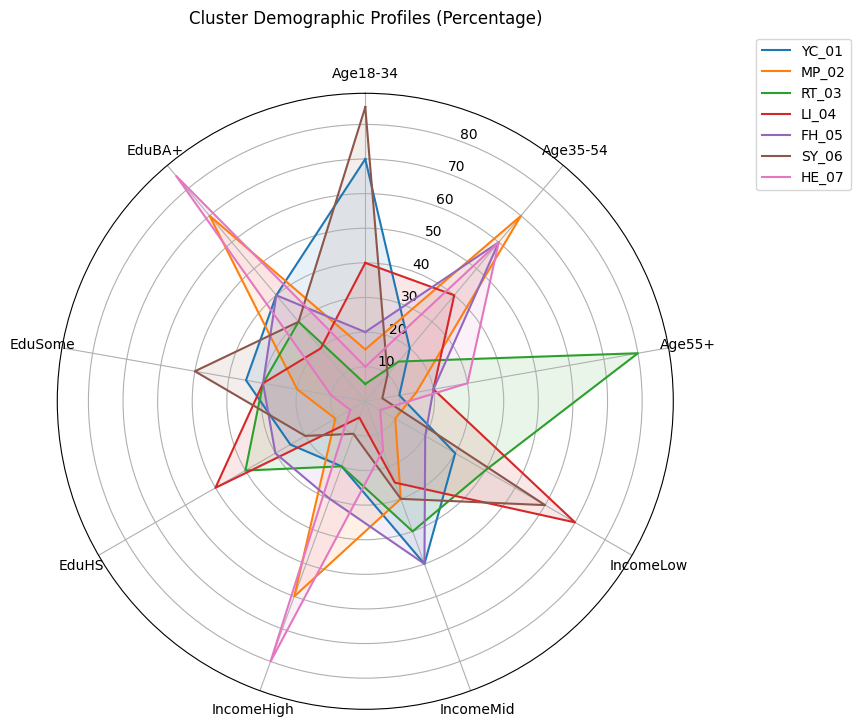

In [33]:
clusters = {
    "YC_01": {"Age18-34": 70, "Age35-54": 20, "Age55+": 10,
              "IncomeLow": 30, "IncomeMid": 50, "IncomeHigh": 20,
              "EduHS": 25, "EduSome": 35, "EduBA+": 40},
    "MP_02": {"Age18-34": 15, "Age35-54": 70, "Age55+": 15,
              "IncomeLow": 10, "IncomeMid": 30, "IncomeHigh": 60,
              "EduHS": 10, "EduSome": 20, "EduBA+": 70},
    "RT_03": {"Age18-34": 5, "Age35-54": 15, "Age55+": 80,
              "IncomeLow": 40, "IncomeMid": 40, "IncomeHigh": 20,
              "EduHS": 40, "EduSome": 30, "EduBA+": 30},
    "LI_04": {"Age18-34": 40, "Age35-54": 40, "Age55+": 20,
              "IncomeLow": 70, "IncomeMid": 25, "IncomeHigh": 5,
              "EduHS": 50, "EduSome": 30, "EduBA+": 20},
    "FH_05": {"Age18-34": 20, "Age35-54": 60, "Age55+": 20,
              "IncomeLow": 20, "IncomeMid": 50, "IncomeHigh": 30,
              "EduHS": 30, "EduSome": 30, "EduBA+": 40},
    "SY_06": {"Age18-34": 85, "Age35-54": 10, "Age55+": 5,
              "IncomeLow": 60, "IncomeMid": 30, "IncomeHigh": 10,
              "EduHS": 20, "EduSome": 50, "EduBA+": 30},
    "HE_07": {"Age18-34": 10, "Age35-54": 60, "Age55+": 30,
              "IncomeLow": 5, "IncomeMid": 15, "IncomeHigh": 80,
              "EduHS": 5, "EduSome": 10, "EduBA+": 85},
}

# Radar chart function
def plot_radar(clusters_data):
    categories = list(next(iter(clusters_data.values())).keys())
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for cluster_id, data in clusters_data.items():
        values = list(data.values())
        values += values[:1]
        ax.plot(angles, values, label=cluster_id)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_rlabel_position(180 / N)
    ax.set_title("Cluster Demographic Profiles (Percentage)", y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Display the radar chart
plot_radar(clusters)

### Generating Activity Schedules

In [8]:
prompt_activity = (
    f"Please generate activity schedules for the clusters: {combined_str}.  "
    "please make sure the generated activity schedule is in the following format: Note this is just a example for format but do not use any value inside for generation\n"
    """
---

### Cluster 1: Example Cluster (Cluster ID: 1)
- **Demographic Influence**: High proportion of young adults (18-34), full-time employment (70%), and nonfamily households (60%). Likely to have structured work schedules and active social lives.
- **Activity Profile**:
  - **Sleep**: Peaks at night (22:00-6:00) with 80-90% asleep, decreases during morning (6:00-8:00) and evening (20:00-22:00).
  - **Work**: High during standard work hours (8:00-17:00) with 50-60% engaged, tapering off in early morning and late evening.
  - **Meal**: Peaks at typical meal times (7:00-8:00, 12:00-13:00, 18:00-19:00) with 20-30% engaged.
  - **Errand**: Moderate during late morning and early evening (10:00-11:00, 17:00-18:00) with 10-15% engaged.
  - **Leisure**: Increases in evening hours (19:00-22:00) with 30-40% engaged, reflecting active social lives.
- **Hourly Breakdown** (fractions sum to 1.0 per hour):
  ```
  Hour   Sleep  Work   Meal   Errand Leisure
  0-1    0.85   0.05   0.00   0.00   0.10
  1-2    0.88   0.03   0.00   0.00   0.09
  2-3    0.90   0.02   0.00   0.00   0.08
  3-4    0.90   0.02   0.00   0.00   0.08
  4-5    0.88   0.03   0.00   0.00   0.09
  5-6    0.85   0.05   0.00   0.00   0.10
  6-7    0.60   0.15   0.15   0.05   0.05
  7-8    0.30   0.30   0.25   0.05   0.10
  8-9    0.10   0.55   0.10   0.10   0.15
  9-10   0.05   0.60   0.05   0.15   0.15
  10-11  0.05   0.60   0.05   0.15   0.15
  11-12  0.05   0.55   0.15   0.10   0.15
  12-13  0.05   0.40   0.30   0.10   0.15
  13-14  0.05   0.55   0.10   0.10   0.20
  14-15  0.05   0.60   0.05   0.10   0.20
  15-16  0.05   0.60   0.05   0.10   0.20
  16-17  0.05   0.55   0.05   0.15   0.20
  17-18  0.05   0.30   0.20   0.20   0.25
  18-19  0.05   0.15   0.30   0.15   0.35
  19-20  0.05   0.10   0.20   0.10   0.55
  20-21  0.10   0.05   0.10   0.05   0.70
  21-22  0.20   0.05   0.05   0.05   0.65
  22-23  0.40   0.05   0.00   0.00   0.55
  23-24  0.60   0.05   0.00   0.00   0.35
  ```

---
    """
)

In [9]:
response = user_proxy.initiate_chat(recipient=aggregated_activity_manager,
    message=prompt_activity
)

User (to AggregatedActivityManager):

Please generate activity schedules for the clusters: ### Cluster 1: Young Commuters - cluster_id: YC_01, population_count: 250000, demographic_summary: Age (18-34: 70%, 35-54: 20%, 55+: 10%), Income (Low: 30%, Middle: 50%, High: 20%), Education (High School: 25%, Some College: 35%, Bachelor's+: 40%), Gender (Male: 52%, Female: 48%), Employment (Full-time: 80%, Part-time: 15%, Unemployed: 5%), Travel Behavior (Public Transit: High, Car: Moderate)### Cluster 2: Middle-Aged Professionals - cluster_id: MP_02, population_count: 300000, demographic_summary: Age (18-34: 15%, 35-54: 70%, 55+: 15%), Income (Low: 10%, Middle: 30%, High: 60%), Education (High School: 10%, Some College: 20%, Bachelor's+: 70%), Gender (Male: 50%, Female: 50%), Employment (Full-time: 85%, Part-time: 10%, Unemployed: 5%), Travel Behavior (Car: High, Public Transit: Moderate)### Cluster 3: Retirees - cluster_id: RT_03, population_count: 200000, demographic_summary: Age (18-34: 5%,

In [10]:
sections = re.split(r'(?m)^[ \t]*---[ \t]*$', response.chat_history[len(response.chat_history)-1]['content'])

clusters = []
for sec in sections:
    sec = sec.strip()
    if not sec.startswith('###'):
        continue

    table_match = re.search(r'```([\s\S]*?)```', sec)
    schedule = table_match.group(1).strip() if table_match else ''

    info = sec
    if table_match:
        info = sec[: table_match.start()].strip()

    clusters.append({
        'info': info,
        'schedule': schedule
    })


In [11]:
schedule = []
for cluster in clusters:
    schedule.append(cluster['schedule'])

In [12]:
schedule_tables = []
for s in schedule:
    lines = [line.strip() for line in s.splitlines() if line.strip()]
    clean_str = "\n".join(lines)
    df = pd.read_csv(StringIO(clean_str), sep=r'\s+', engine='python', index_col=0)
    schedule_tables.append(df)

In [13]:
def plot_cluster_heatmaps(schedule_tables):
    """
    Plots a heatmap for each cluster's activity schedule in subplots.

    Parameters:
    - schedule_tables: List of pandas DataFrames.
        Each DataFrame should have hourly bins as the index (e.g., '0-1', '1-2', ..., '23-24')
        and activity types as columns (e.g., 'Sleep', 'Work', 'Meal', 'Errand', 'Leisure').

    The function will dynamically arrange subplots based on the number of clusters.
    """
    n_clusters = len(schedule_tables)
    ncols = 4         # Number of columns in the subplot grid
    nrows = math.ceil(n_clusters / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15))
    axes = axes.flatten()
    
    for idx, df in enumerate(schedule_tables):
        ax = axes[idx]
        im = ax.imshow(df.values, aspect='auto')
        
        ax.set_title(f'Cluster {idx + 1}')
        ax.set_xticks(range(df.shape[1]))
        ax.set_xticklabels(df.columns, rotation=45, ha='right')
        ax.set_yticks(range(df.shape[0]))
        ax.set_yticklabels(df.index)
    
    # Hide any unused subplots
    for j in range(n_clusters, len(axes)):
        axes[j].axis('off')
    
    #cbar = fig.colorbar(im, ax=axes[:n_clusters].tolist(), orientation='vertical', fraction=0.02, pad=0.04)
    #cbar.set_label('Fraction of Population')

    fig.tight_layout()
    plt.show()

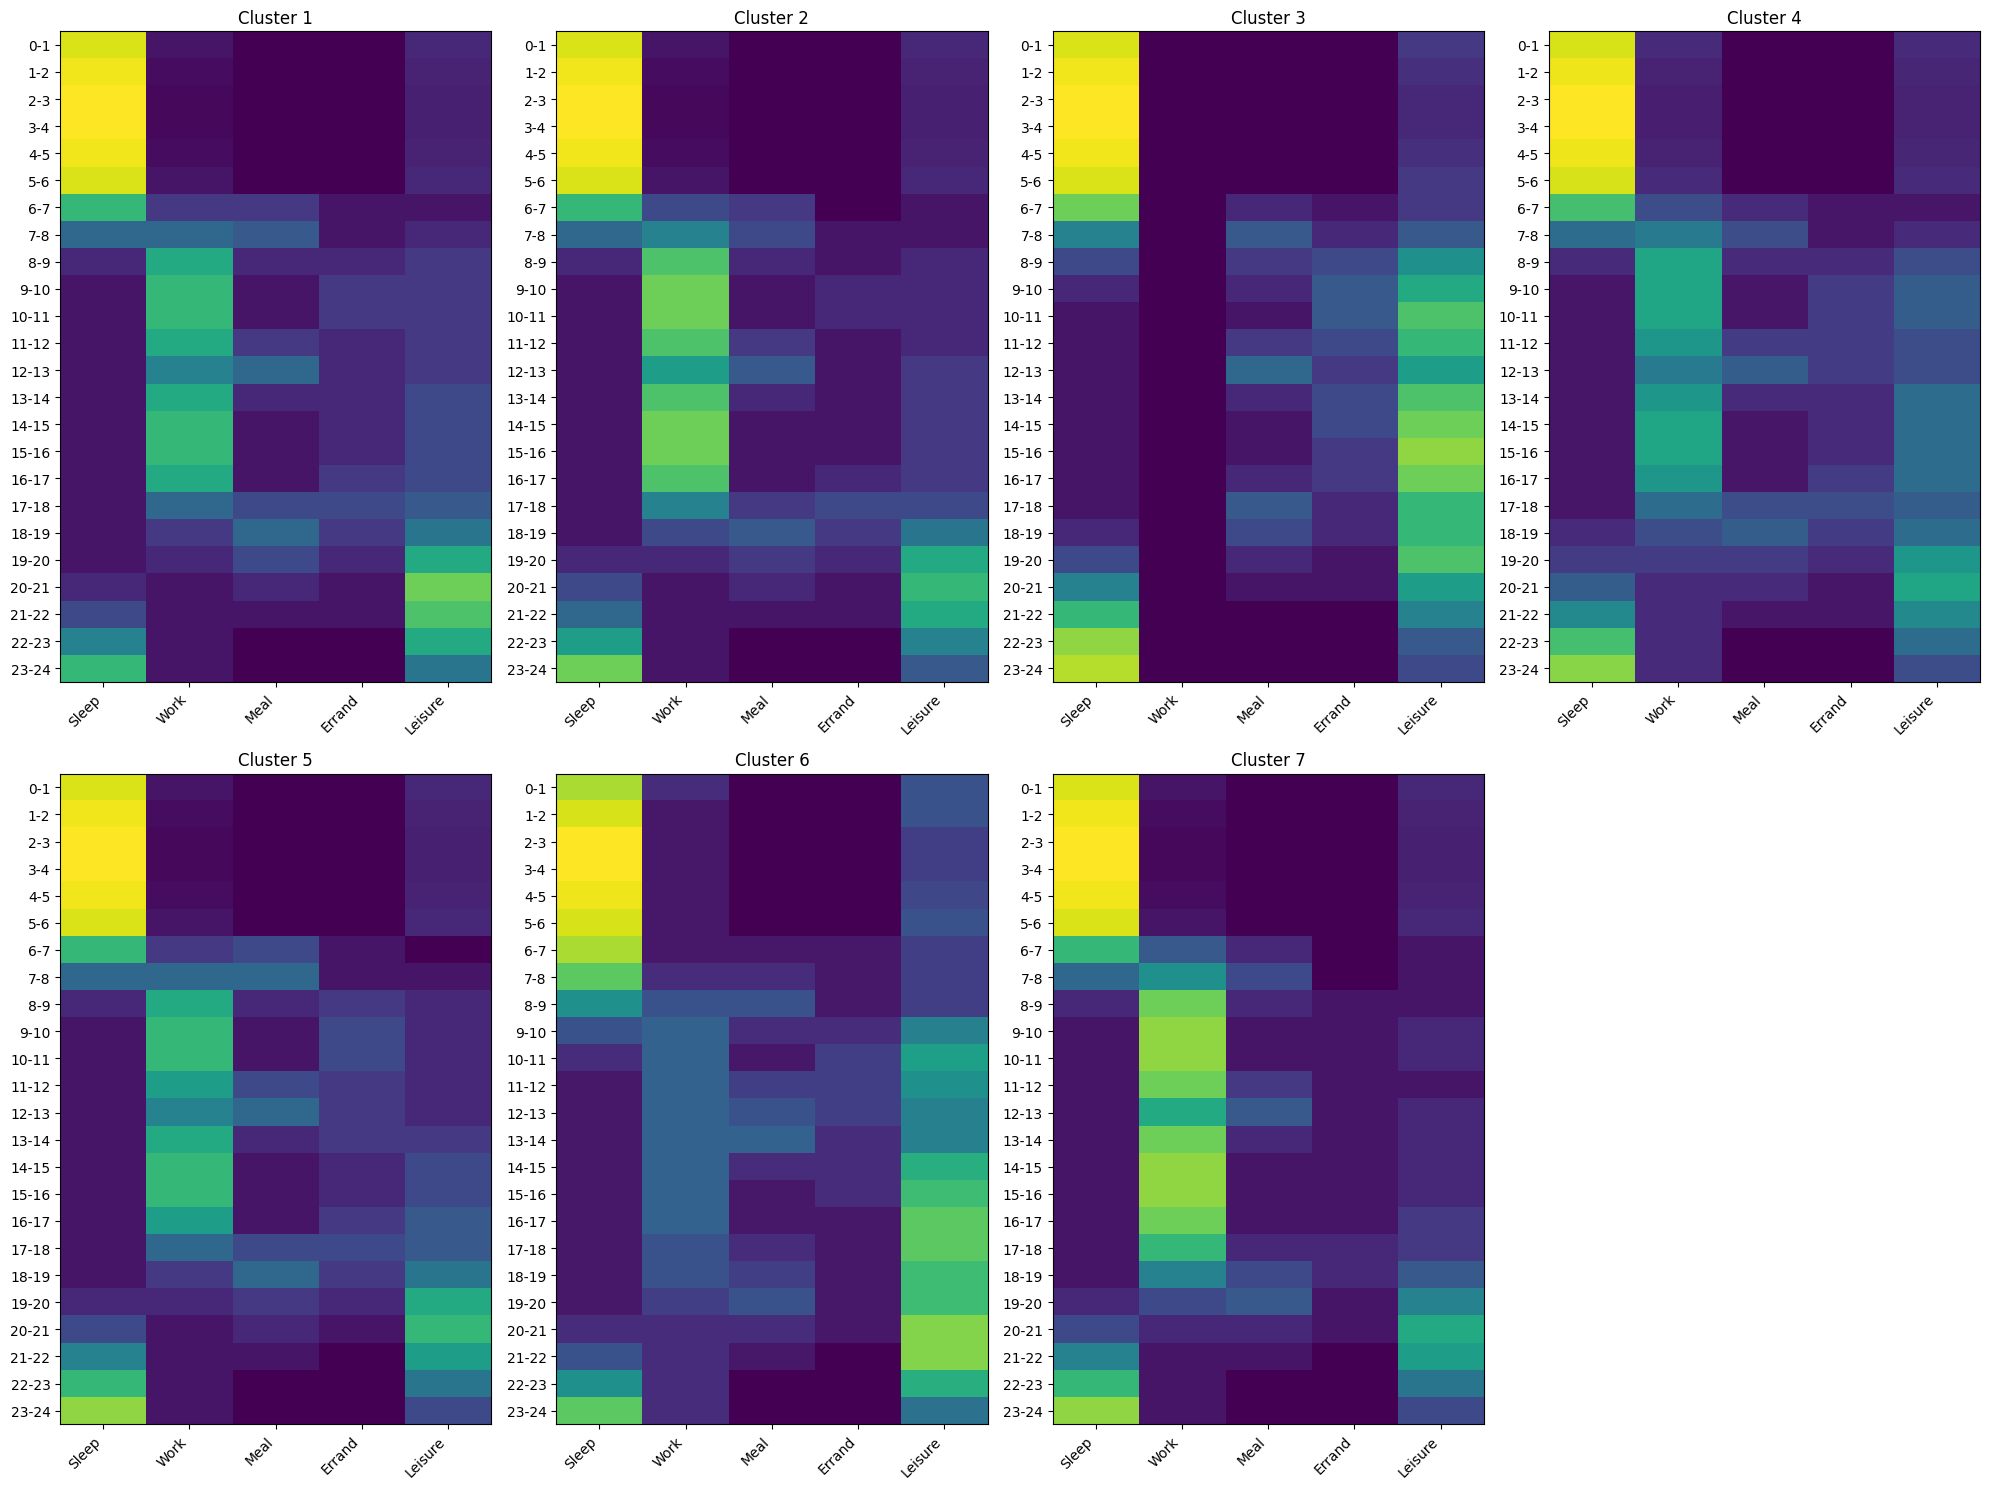

In [14]:
plot_cluster_heatmaps(schedule_tables)

### Generating Mobility Patterns

In [15]:
def combine_info_and_schedule(clusters):
    """
    将每个字典的 'info' 和 'schedule' 字段按顺序合并为一个字符串。
    """
    parts = []
    for cluster in clusters:
        parts.append(cluster.get('info', ''))
        if 'schedule' in cluster:
            parts.append(cluster['schedule'])
    return "\n\n".join(parts)

In [16]:
combined_str_act = combine_info_and_schedule(clusters)

In [43]:

prompt_mobility = (
    f"The detailed info of clusters are given: {combined_str_act}.  "
    "Please generate the mobility patterns for each cluster.  "
    "The generated mobility patterns should be in the following format: - Origin: 0, Destination: 0, Hour: 0-1, Cluster: YC_01, People: 82, Leaving: residential, Heading: residential, Activity: Sleep->Sleep, Note this is just a example for format but do not use any value inside for generation\n, for here only generate time 8-9"
)

In [44]:
response = user_proxy.initiate_chat(recipient=aggregated_mobility_manager,
    message=prompt_mobility
)

User (to AggregatedMobilityManager):

The detailed info of clusters are given: ### Cluster 1: Young Commuters (Cluster ID: YC_01)
- **Demographic Influence**: High proportion of young adults (18-34: 70%), full-time employment (80%), and reliance on public transit. Likely to have structured work schedules, active social lives, and longer commutes.
- **Activity Profile**:
  - **Sleep**: Peaks at night (22:00-6:00) with 80-90% asleep, decreases during morning (6:00-8:00) and evening (20:00-22:00).
  - **Work**: High during standard work hours (8:00-17:00) with 50-60% engaged, reflecting full-time employment and commuting patterns.
  - **Meal**: Peaks at typical meal times (7:00-8:00, 12:00-13:00, 18:00-19:00) with 20-30% engaged.
  - **Errand**: Moderate during late morning and early evening (10:00-11:00, 17:00-18:00) with 10-15% engaged.
  - **Leisure**: Increases in evening hours (19:00-22:00) with 30-40% engaged, reflecting active social lives of young adults.
- **Hourly Breakdown** (f

- Origin: 0, Destination: 0, Hour: 8-9, Cluster: YC_01, People: 1217, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 0, Hour: 8-9, Cluster: MP_02, People: 1439, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 0, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: residential, Activity: Sleep->Leisure
- Origin: 0, Destination: 0, Hour: 8-9, Cluster: LI_04, People: 1106, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 0, Hour: 8-9, Cluster: FH_05, People: 1217, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 0, Hour: 8-9, Cluster: SY_06, People: 442, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 0, Hour: 8-9, Cluster: HE_07, People: 1549, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 1, Hour: 8-9, Cluster: YC_01, People: 68, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 1, Hour: 8-9, Cluster: MP_02, People: 80, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 1, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 1, Hour: 8-9, Cluster: LI_04, People: 61, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 1, Hour: 8-9, Cluster: FH_05, People: 68, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 1, Hour: 8-9, Cluster: SY_06, People: 25, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 1, Hour: 8-9, Cluster: HE_07, People: 86, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 2, Hour: 8-9, Cluster: YC_01, People: 71, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 2, Hour: 8-9, Cluster: MP_02, People: 83, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 2, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 2, Hour: 8-9, Cluster: LI_04, People: 64, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 2, Hour: 8-9, Cluster: FH_05, People: 71, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 2, Hour: 8-9, Cluster: SY_06, People: 26, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 2, Hour: 8-9, Cluster: HE_07, People: 89, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 3, Hour: 8-9, Cluster: YC_01, People: 265, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 3, Hour: 8-9, Cluster: MP_02, People: 313, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 3, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 3, Hour: 8-9, Cluster: LI_04, People: 241, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 3, Hour: 8-9, Cluster: FH_05, People: 265, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 3, Hour: 8-9, Cluster: SY_06, People: 96, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 3, Hour: 8-9, Cluster: HE_07, People: 337, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 4, Hour: 8-9, Cluster: YC_01, People: 30, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 4, Hour: 8-9, Cluster: MP_02, People: 35, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 4, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 4, Hour: 8-9, Cluster: LI_04, People: 27, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 4, Hour: 8-9, Cluster: FH_05, People: 30, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 4, Hour: 8-9, Cluster: SY_06, People: 11, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 4, Hour: 8-9, Cluster: HE_07, People: 37, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 5, Hour: 8-9, Cluster: YC_01, People: 37, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 5, Hour: 8-9, Cluster: MP_02, People: 43, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 5, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 5, Hour: 8-9, Cluster: LI_04, People: 33, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 5, Hour: 8-9, Cluster: FH_05, People: 37, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 5, Hour: 8-9, Cluster: SY_06, People: 13, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 5, Hour: 8-9, Cluster: HE_07, People: 46, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 6, Hour: 8-9, Cluster: YC_01, People: 8, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 6, Hour: 8-9, Cluster: MP_02, People: 9, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 6, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 6, Hour: 8-9, Cluster: LI_04, People: 7, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 6, Hour: 8-9, Cluster: FH_05, People: 8, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 6, Hour: 8-9, Cluster: SY_06, People: 3, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 6, Hour: 8-9, Cluster: HE_07, People: 10, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 7, Hour: 8-9, Cluster: YC_01, People: 29, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 7, Hour: 8-9, Cluster: MP_02, People: 34, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 7, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 7, Hour: 8-9, Cluster: LI_04, People: 26, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 7, Hour: 8-9, Cluster: FH_05, People: 29, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 7, Hour: 8-9, Cluster: SY_06, People: 11, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 7, Hour: 8-9, Cluster: HE_07, People: 36, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 8, Hour: 8-9, Cluster: YC_01, People: 11, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 8, Hour: 8-9, Cluster: MP_02, People: 13, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 8, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 8, Hour: 8-9, Cluster: LI_04, People: 10, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 8, Hour: 8-9, Cluster: FH_05, People: 11, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 8, Hour: 8-9, Cluster: SY_06, People: 4, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 8, Hour: 8-9, Cluster: HE_07, People: 14, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 9, Hour: 8-9, Cluster: YC_01, People: 189, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 9, Hour: 8-9, Cluster: MP_02, People: 223, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 9, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 9, Hour: 8-9, Cluster: LI_04, People: 172, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 9, Hour: 8-9, Cluster: FH_05, People: 189, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 9, Hour: 8-9, Cluster: SY_06, People: 69, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 9, Hour: 8-9, Cluster: HE_07, People: 240, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 10, Hour: 8-9, Cluster: YC_01, People: 33, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 10, Hour: 8-9, Cluster: MP_02, People: 39, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 10, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 10, Hour: 8-9, Cluster: LI_04, People: 30, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 10, Hour: 8-9, Cluster: FH_05, People: 33, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 10, Hour: 8-9, Cluster: SY_06, People: 12, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 10, Hour: 8-9, Cluster: HE_07, People: 42, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 11, Hour: 8-9, Cluster: YC_01, People: 32, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 11, Hour: 8-9, Cluster: MP_02, People: 38, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 11, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 11, Hour: 8-9, Cluster: LI_04, People: 29, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 11, Hour: 8-9, Cluster: FH_05, People: 32, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 11, Hour: 8-9, Cluster: SY_06, People: 12, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 11, Hour: 8-9, Cluster: HE_07, People: 41, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 12, Hour: 8-9, Cluster: YC_01, People: 34, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 12, Hour: 8-9, Cluster: MP_02, People: 40, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 12, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 12, Hour: 8-9, Cluster: LI_04, People: 31, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 12, Hour: 8-9, Cluster: FH_05, People: 34, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 12, Hour: 8-9, Cluster: SY_06, People: 12, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 12, Hour: 8-9, Cluster: HE_07, People: 43, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 13, Hour: 8-9, Cluster: YC_01, People: 0, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 13, Hour: 8-9, Cluster: MP_02, People: 0, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 13, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 13, Hour: 8-9, Cluster: LI_04, People: 0, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 13, Hour: 8-9, Cluster: FH_05, People: 0, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 13, Hour: 8-9, Cluster: SY_06, People: 0, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 13, Hour: 8-9, Cluster: HE_07, People: 0, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 14, Hour: 8-9, Cluster: YC_01, People: 26, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 14, Hour: 8-9, Cluster: MP_02, People: 31, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 14, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 14, Hour: 8-9, Cluster: LI_04, People: 24, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 14, Hour: 8-9, Cluster: FH_05, People: 26, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 14, Hour: 8-9, Cluster: SY_06, People: 10, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 14, Hour: 8-9, Cluster: HE_07, People: 33, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 15, Hour: 8-9, Cluster: YC_01, People: 29, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 15, Hour: 8-9, Cluster: MP_02, People: 35, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 15, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 15, Hour: 8-9, Cluster: LI_04, People: 27, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 15, Hour: 8-9, Cluster: FH_05, People: 29, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 15, Hour: 8-9, Cluster: SY_06, People: 11, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 15, Hour: 8-9, Cluster: HE_07, People: 37, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 16, Hour: 8-9, Cluster: YC_01, People: 41, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 16, Hour: 8-9, Cluster: MP_02, People: 48, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 16, Hour: 8-9, Cluster: RT_03, People: 0, Leaving: residential, Heading: entertainment, Activity: Sleep->Leisure
- Origin: 0, Destination: 16, Hour: 8-9, Cluster: LI_04, People: 37, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 16, Hour: 8-9, Cluster: FH_05, People: 41, Leaving: residential, Heading: commercial, Activity: Sleep->Work
- Origin: 0, Destination: 16, Hour: 8-9, Cluster: SY_06, People: 15, Leaving: residential, Heading: education, Activity: Sleep->Work
- Origin: 0, Destination: 16, Hour: 8-9, Cluster: HE_07, People: 52, Leaving: residential, Heading: commercial, Activity: Sleep->Work

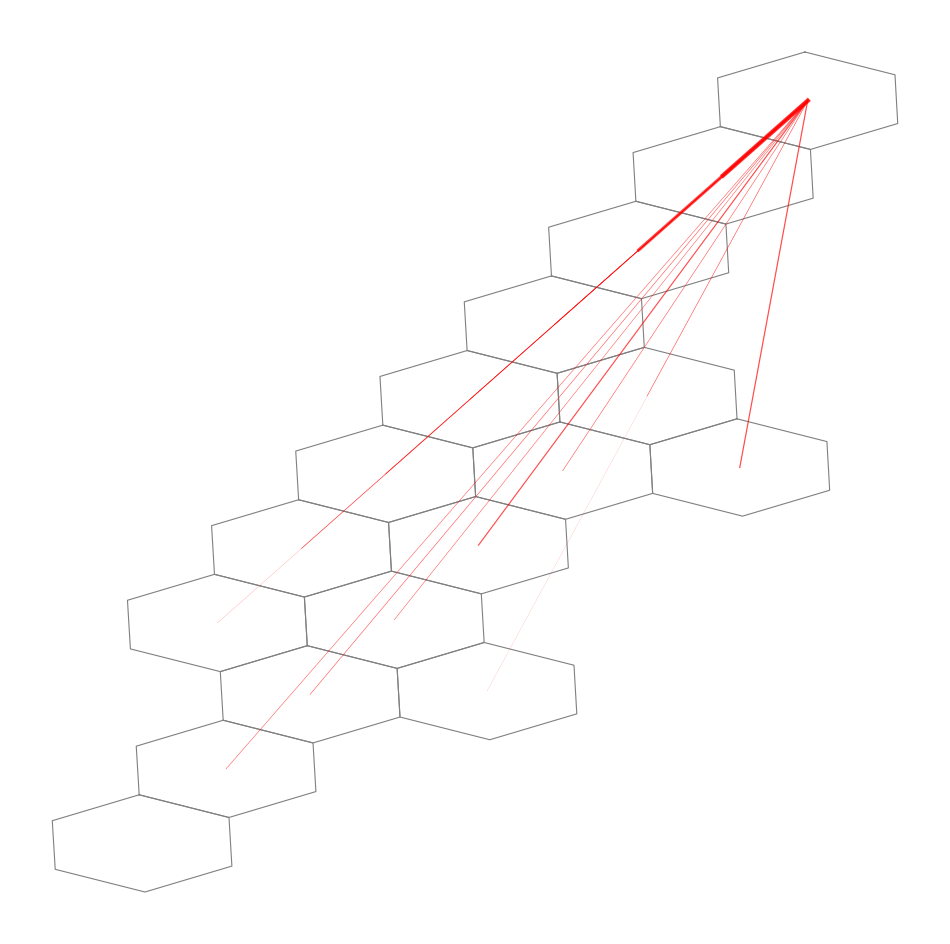

In [48]:
import matplotlib.pyplot as plt
from shapely.geometry import shape, LineString


with open('CityHex20Exp/new-york-city-boroughs.geojson', 'r') as f:
    geojson = json.load(f)
hex_polys = [shape(feat["geometry"]) for feat in geojson["features"]]
centroids = [poly.centroid for poly in hex_polys]

data = [
    {"origin":0,"destination":0,"people":1217},
    {"origin":0,"destination":1,"people":68},
    {"origin":0,"destination":2,"people":71},
    {"origin":0,"destination":3,"people":265},
    {"origin":0,"destination":4,"people":30},
    {"origin":0,"destination":5,"people":37},
    {"origin":0,"destination":6,"people":8},
    {"origin":0,"destination":7,"people":29},
    {"origin":0,"destination":8,"people":11},
    {"origin":0,"destination":9,"people":189},
    {"origin":0,"destination":10,"people":33},
    {"origin":0,"destination":11,"people":32},
    {"origin":0,"destination":12,"people":34},
    {"origin":0,"destination":14,"people":26},
    {"origin":0,"destination":15,"people":29},
    {"origin":0,"destination":16,"people":41},
]

fig, ax = plt.subplots(figsize=(12, 12))

for poly in hex_polys:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='gray', linewidth=0.8)

max_people = max(item["people"] for item in data)
for item in data:
    orig = centroids[item["origin"]]
    dest = centroids[item["destination"]]
    line = LineString([orig, dest])
    ax.plot(*line.xy, linewidth=(item["people"]/max_people)*15, alpha=0.7, color='red')

ax.set_axis_off()
plt.show()
